## Search

### Overview and Feature Justification

This project is centered around finding unnecessary search terms. We can reduce our costs by reducing the number of api calls we're making on these unnecessary terms. 

### Process

Is it a hashtag? Is it a term that just retailers use? We can look at social buzz and retail distribution to give us more insight. We can also double check to make sure our customers aren't searching for these terms.
<img src="flow.png" width="500">

### Initial setup
Import appropriate libraries, read in the CSV, delete unnecessary columns, and sort by total volume

In [1]:
# pandas setup
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time

In [2]:
# read in csv
search_df=pd.read_csv("search.csv")

#remove irrelevant columns
search_df.drop(search_df.columns[[12,13,14,15]], axis=1, inplace=True)
search_df.head(10)
search_df['total_volume'] = search_df.sum(axis=1)
search_df.drop(search_df.columns[[1,2,3,4,5,6,7,8,9,10,11]], axis=1, inplace=True)

# display first 10 rows
search_df.head(10)

,trend,total_volume
0,duchesse satin gown,0
1,saksutopia,0
2,oscars2016,0
3,studded apparel,90
4,pompon charm,0
5,cfdaawards,480
6,billboardmusicawards,1260
7,wool crepe jacket,180
8,foil gown,280
9,loose cut trousers,100


### Helper Functions

In [ ]:
def get_social_buzz(term):
    
    # base API endpoint url
    base_url = "https://api.trendalytics.co/v1/brand/posts/latest?brand=&limit=50&order=desc&period=2016-03-21:2016-04-19&platform=facebook,pinterest,twitter,instagram,tumblr&q="
    # convert term like 'pink wedding dress' to 'pink+wedding+dress'
    encoded_term = urllib.quote_plus(term)
    base_end_url = "&sort=total"
    url = base_url + encoded_term + base_end_url
    
    # set authorization
    headers = {'authorization': 'NGRiZmUzMzktZTg4Ny00MTE4LWIyNzgtZTcwNWQxYjE3NzZmOnZWRDBPLzVDR3FCWllGQUtSZnphWVBDNWJJdz0='}
     
    # get response
    response = requests.get(url, headers=headers)
    response_json = json.loads(response.text)
    
    # get the number of total posts from response json
    total_posts = 0
    for platform_stats in response_json["facets"]["platformStatsFacet"]["terms"]:
        platform_total_posts = platform_stats["total_count"]
        total_posts = total_posts + platform_total_posts

    return total_posts

In [6]:
# sort the df by total_volume
sorted_search_df = search_df.sort('total_volume', ascending=True)

sorted_search_df.head(10)

,trend,total_volume
0,duchesse satin gown,0
5620,nordstromyvr,0
5618,pleated long skirt,0
5489,hanbang mask pack,0
5490,mens braided melt,0
5494,cold shoulder mock neck top,0
5495,cherry red sequin,0
5623,patent gown,0
5498,twin cake pact,0
5502,wrap front gown,0


In [7]:
# get stats on search volume
sorted_search_df['total_volume'].describe()

count    5.656000e+03
mean     1.228152e+06
std      6.786063e+06
min      0.000000e+00
25%      9.605000e+03
50%      6.405000e+04
75%      3.817000e+05
max      2.794000e+08
Name: total_volume, dtype: float64

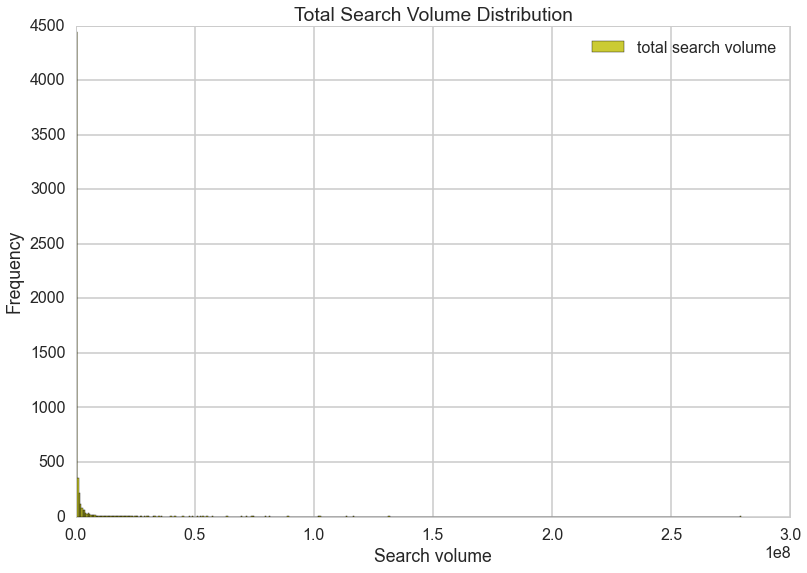

In [8]:
# plot what this looks like
total_volume=np.array(sorted_search_df.total_volume)
plt.figure()
plt.hist(total_volume, alpha=.8, color='y', bins=500, label="total search volume")
plt.xlabel('Search volume')
plt.ylabel('Frequency')
plt.title('Total Search Volume Distribution')
plt.legend()
plt.show()

Looks like there are a ton of searches with very little volume, and very few searches with a ton of volume (which sees to make sense)

## What's the difference between NaN and 0 search volume?

### Another way to do this is to do comparisons...

### Finding insignificant searches

Keep track of whether there are insignificant searches

In [9]:
# get the bottom 5 percentile in terms of search volume
low_search_value = sorted_search_df.total_volume.quantile(0.05)
print "low search value:" + str(low_search_value)
# create new df with low searches
low_search_df = sorted_search_df[sorted_search_df.total_volume < low_search_value]
low_search_df.head(10)

low search value:367.5


,trend,total_volume
0,duchesse satin gown,0
5620,nordstromyvr,0
5618,pleated long skirt,0
5489,hanbang mask pack,0
5490,mens braided melt,0
5494,cold shoulder mock neck top,0
5495,cherry red sequin,0
5623,patent gown,0
5498,twin cake pact,0
5502,wrap front gown,0


In [10]:
# save work to a csv file
low_search_df.to_csv('lowsearch-hashtags.csv')

### Classify these insignificant searches

Is it a hashtag? Is it a term that just retailers use? We can look at social buzz and retail distribution to give us more insight. We can also double check to make sure our customers aren't searching for these terms.
<img src="flow.png" width="500">

#### Do they have social buzz?

Determine whether these have social buzz

In [11]:
import requests
import json
import urllib

In [12]:
# gets total number of posts
# for now just gets the associated json
def get_social_buzz(term):
    
    # base API endpoint url
    base_url = "https://api.trendalytics.co/v1/brand/posts/latest?brand=&limit=50&order=desc&period=2016-03-21:2016-04-19&platform=facebook,pinterest,twitter,instagram,tumblr&q="
    # convert term like 'pink wedding dress' to 'pink+wedding+dress'
    encoded_term = urllib.quote_plus(term)
    base_end_url = "&sort=total"
    url = base_url + encoded_term + base_end_url
    
    # set authorization
    headers = {'authorization': 'NGRiZmUzMzktZTg4Ny00MTE4LWIyNzgtZTcwNWQxYjE3NzZmOnZWRDBPLzVDR3FCWllGQUtSZnphWVBDNWJJdz0='}
     
    # get response
    response = requests.get(url, headers=headers)
    response_json = json.loads(response.text)
    
    # get the number of total posts from response json
    total_posts = 0
    for platform_stats in response_json["facets"]["platformStatsFacet"]["terms"]:
        platform_total_posts = platform_stats["total_count"]
        total_posts = total_posts + platform_total_posts

    return total_posts

In [13]:
# get total posts from all with low social
social_buzz = []
for term in low_search_df["trend"]:
    total_posts = get_social_buzz(term)
    social_buzz.append(total_posts)

In [14]:
# low_search_df.drop('social_buzz', 1)

In [15]:
# add the social buzz column
low_search_df.loc[:,'social_buzz'] = social_buzz
# sort the df by total_volume
sorted_social_df = low_search_df.sort('social_buzz', ascending=True)
sorted_social_df.head(5)

/Users/eden/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/eden/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,trend,total_volume,social_buzz
5358,mixed media satchel,0,0
130,crocodile embossed bag,70,0
104,cable knit nail,80,0
17,levis womens denim,90,0
34,extreme spread collar dress shirt,90,0


interestingly enough, looks like the majority of these with no search volume actually don't have any social media buzz either

In [16]:
sorted_social_df["social_buzz"].describe()

count    283.000000
mean      10.950530
std       67.376346
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      896.000000
Name: social_buzz, dtype: float64

to graph what this looks like

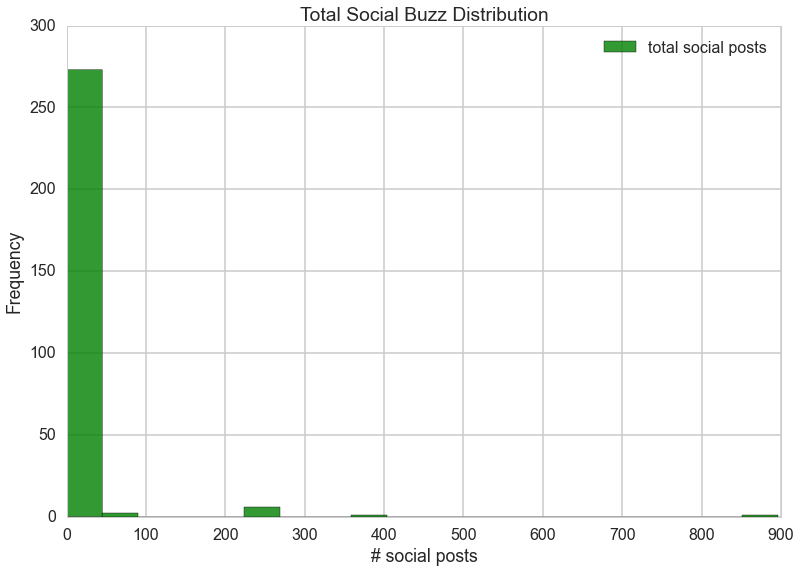

In [17]:
# plot what this looks like
total_social=np.array(sorted_social_df.social_buzz)
plt.figure()
plt.hist(total_social, alpha=.8, color='g', bins=20, label="total social posts")
plt.xlabel('# social posts')
plt.ylabel('Frequency')
plt.title('Total Social Buzz Distribution')
plt.legend()
plt.show()

The majority of our terms with low search volume, also have low social buzz (according to the stats below, literally 81%!) 
### Eventually need a more sophisticated mechanism for figuring out whether the other 19% are hashtags or not

In [19]:
# get the bottom 5 percentile in terms of social volume
low_social_value = sorted_social_df.social_buzz.quantile(0.81)
print "low social value:" + str(low_social_value)
# create new df with low social
sorted_social_df['low_social'] = (sorted_social_df.social_buzz <= low_social_value)
sorted_social_df.head(10)

low social value:0.0


,trend,total_volume,social_buzz,low_social
5358,mixed media satchel,0,0,True
130,crocodile embossed bag,70,0,True
104,cable knit nail,80,0,True
17,levis womens denim,90,0,True
34,extreme spread collar dress shirt,90,0,True
3,studded apparel,90,0,True
152,skinny tapered pants,100,0,True
9,loose cut trousers,100,0,True
5361,chaturanga pant,100,0,True
32,mkshanghai,110,0,True


### Finding the most likely hashtags

In [38]:
high_social_value = sorted_social_df.social_buzz.quantile(0.96)
print "high social value:" + str(high_social_value)

high social value:22.36


In [42]:
high_social_df = sorted_social_df[sorted_social_df.social_buzz >= high_social_value]
high_social_df

,trend,total_volume,social_buzz,low_social
5277,nordstromvan,0,26,False
36,microdermobrasian,120,32,False
76,eye shawdow palette,190,74,False
5367,londonfashionwk,0,79,False
5471,bumpchic,0,224,False
5338,pregnantfashion,0,233,False
27,pregnancyfashion,120,233,False
5540,pregnantstyle,0,244,False
5309,pregnancystyle,0,244,False
35,maternityfashion,190,260,False


Looks like there are 12 likely hashtags

In [41]:
len(high_social_df)

12

In [44]:
# save work and export to csv
high_social_df.to_csv('highsocial-hashtags.csv')

#### Do the have retail distribution?

Look at products on the market with ShopStyle's API to see if there is retail distribution

In [80]:
def get_retail_distribution(term):
    # base API endpoint url
    base_url = 'http://api.shopstyle.com/api/v2/products?filters=Category%2CBrand%2CRetailer%2CPrice%2CDiscount%2CSize%2CColor%2CDeal&fts='
#     base_url = 'https://app.trendalytics.co/api/v1/api/v2/products?filters=Category%2CBrand%2CRetailer%2CPrice%2CDiscount%2CSize%2CColor%2CDeal&fts='
    # convert term like 'pink wedding dress' to 'pink+wedding+dress'
    encoded_term = urllib.quote_plus(term)
    end_url = '&pid=shopstyle'
    url = base_url + encoded_term + end_url
    # set authorization
#     headers = {'authorization': 'NGRiZmUzMzktZTg4Ny00MTE4LWIyNzgtZTcwNWQxYjE3NzZmOnZWRDBPLzVDR3FCWllGQUtSZnphWVBDNWJJdz0='}
    
    # get response
#     response = requests.get(url, headers=headers)
    response = requests.get(url)
    response_json = json.loads(response.text)
    
    # get # total products
    total_products = response_json['metadata']['total']
    
    return total_products

In [81]:
# total_products = get_retail_distribution('precision lip brush')
# print total_products

In [82]:
# get the retail distribution for all terms
retail_distribution = []
for term in list(high_social_df["trend"]):
    total_products = get_retail_distribution(term)
    retail_distribution.append(total_products)

In [71]:
retail_distribution

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
# add the social buzz column
high_social_df.loc[:,'retail_distribution'] = retail_distribution
# sort the df by total_volume
sorted_retail_df = high_social_df.sort('retail_distribution', ascending=True)
sorted_retail_df

,trend,total_volume,social_buzz,low_social,retail_distribution
5277,nordstromvan,0,26,False,0
36,microdermobrasian,120,32,False,0
76,eye shawdow palette,190,74,False,0
5367,londonfashionwk,0,79,False,0
5471,bumpchic,0,224,False,0
5338,pregnantfashion,0,233,False,0
27,pregnancyfashion,120,233,False,0
5540,pregnantstyle,0,244,False,0
5309,pregnancystyle,0,244,False,0
35,maternityfashion,190,260,False,0


### Search vs social buzz volume
There should be more social buzz than search volume for hashtags

In [83]:
high_social_df['more_social'] = (high_social_df.social_buzz >= high_social_df.total_volume)

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [85]:
high_social_df.head(10)

,trend,total_volume,social_buzz,low_social,retail_distribution,more_social
5277,nordstromvan,0,26,False,0,True
36,microdermobrasian,120,32,False,0,False
76,eye shawdow palette,190,74,False,0,False
5367,londonfashionwk,0,79,False,0,True
5471,bumpchic,0,224,False,0,True
5338,pregnantfashion,0,233,False,0,True
27,pregnancyfashion,120,233,False,0,True
5540,pregnantstyle,0,244,False,0,True
5309,pregnancystyle,0,244,False,0,True
35,maternityfashion,190,260,False,0,True


In [86]:
hashtags_df = high_social_df[high_social_df['more_social']]
hashtags_df

,trend,total_volume,social_buzz,low_social,retail_distribution,more_social
5277,nordstromvan,0,26,False,0,True
5367,londonfashionwk,0,79,False,0,True
5471,bumpchic,0,224,False,0,True
5338,pregnantfashion,0,233,False,0,True
27,pregnancyfashion,120,233,False,0,True
5540,pregnantstyle,0,244,False,0,True
5309,pregnancystyle,0,244,False,0,True
35,maternityfashion,190,260,False,0,True
31,maternitystyle,230,389,False,0,True
5353,bridalfashionweek,150,896,False,0,True


The rest seem to be typos

In [91]:
typos_df = high_social_df[high_social_df['more_social'] == 0]
typos_df

,trend,total_volume,social_buzz,low_social,retail_distribution,more_social
36,microdermobrasian,120,32,False,0,False
76,eye shawdow palette,190,74,False,0,False


In [92]:
typos_df.to_csv('typos-conservative.csv')

### Another option

Looks like simply comparing social buzz to total volume was actually super effective at identifying hashtags. Let's do that at the get go to start off with. 

#### Get social buzz for all search terms

The following code takes forever to run, so save it to csv asap

In [93]:
# get total posts from all with low social
social_buzz = []
for term in search_df["trend"]:
    total_posts = get_social_buzz(term)
    social_buzz.append(total_posts)

In [94]:
# Now add this to the df
search_df.loc[:,'social_buzz'] = social_buzz

In [95]:
search_df.to_csv('searchandsocial.csv')

In [96]:
search_df.head(5)

,trend,total_volume,social_buzz
0,duchesse satin gown,0,2
1,saksutopia,0,0
2,oscars2016,0,9
3,studded apparel,90,0
4,pompon charm,0,0


Let's graph how this looks

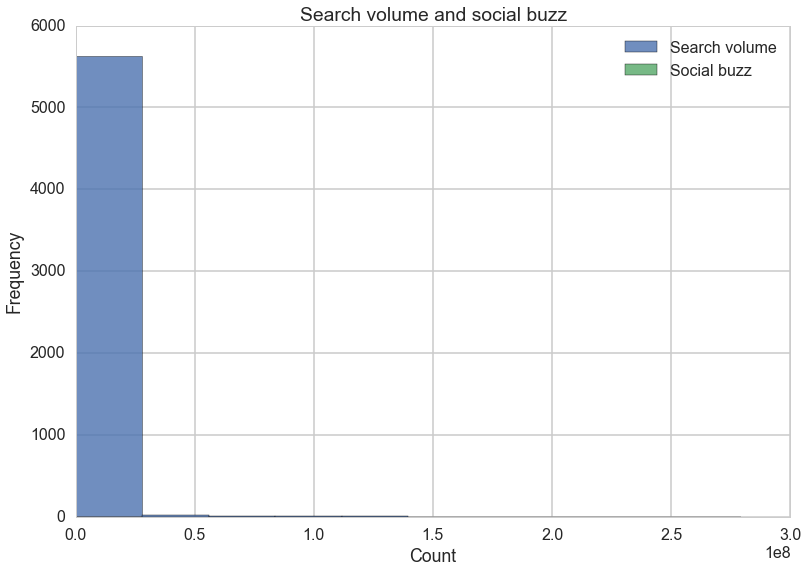

In [97]:
plt.figure()
plt.hist(search_df.total_volume, alpha=.8, label="Search volume")
plt.legend()
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Search volume')
plt.show()

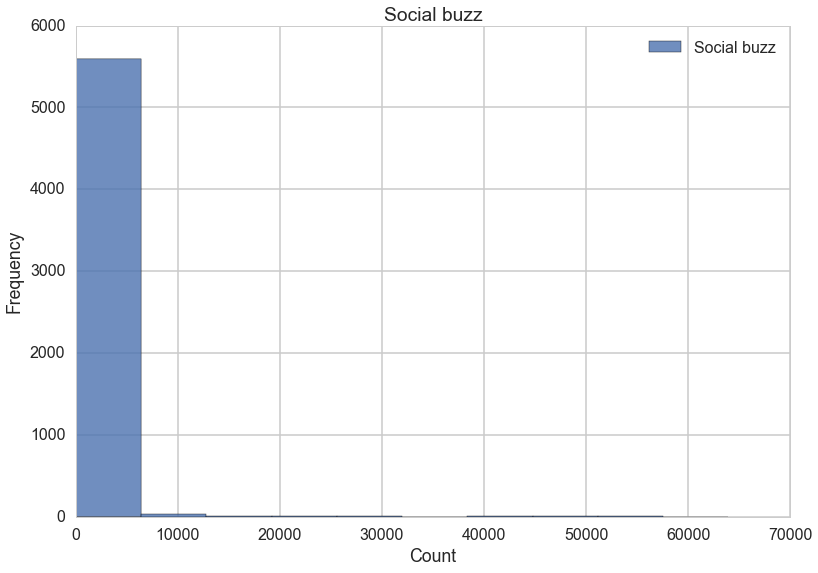

In [102]:
plt.figure()
plt.hist(search_df.social_buzz, alpha=.8, label="Social buzz")
plt.legend()
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Social buzz')
plt.show()

### We might need to do some normalization here to make adequate comparisons - we should just see what makes the most sense

#### Which terms have literally more social buzz than search volume

In [98]:
# add a new column
search_df['more_social'] = (search_df['social_buzz'] >= search_df['total_volume'])
# also create a new df with only the terms with more social buzz than search volume
search_social_df = search_df['more_social']

In [101]:
print "# of terms with more social than search: " + str(len(search_social_df))
search_social_df['social_buzz'].describe()

# of terms with more social than search159


count    159.000000
mean      18.295597
std       89.519148
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      896.000000
Name: social_buzz, dtype: float64

In [103]:
social_mean = search_social_df['social_buzz'].mean()
search_social_df['high_social'] = (search_social_df['social_buzz'] >= social_mean)
search_social_df.head()

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,trend,total_volume,social_buzz,more_social,high_social
0,duchesse satin gown,0,2,True,False
1,saksutopia,0,0,True,False
2,oscars2016,0,9,True,False
4,pompon charm,0,0,True,False
27,pregnancyfashion,120,233,True,True


In [109]:
high_more_social_df = search_social_df[search_social_df['high_social']]
high_more_social_df

,trend,total_volume,social_buzz,more_social,high_social
27,pregnancyfashion,120,233,True,True
31,maternitystyle,230,389,True,True
35,maternityfashion,190,283,True,True
5277,nordstromvan,0,26,True,True
5309,pregnancystyle,0,244,True,True
5338,pregnantfashion,0,233,True,True
5353,bridalfashionweek,150,896,True,True
5367,londonfashionwk,0,79,True,True
5471,bumpchic,0,224,True,True
5540,pregnantstyle,0,244,True,True


#### Just see which ones are one word and have low search OR high social_buzz


In [113]:
def is_one_word(word):
    if len(word.split()) > 1:
        return False
    return True

In [117]:
df = search_df
df.head(2)

,trend,total_volume,social_buzz,more_social
0,duchesse satin gown,0,2,True
1,saksutopia,0,0,True


In [119]:
df['one_word'] = df['trend'].apply(lambda trend: is_one_word(trend))

In [121]:
df.head(5)

,trend,total_volume,social_buzz,more_social,one_word
0,duchesse satin gown,0,2,True,False
1,saksutopia,0,0,True,True
2,oscars2016,0,9,True,True
3,studded apparel,90,0,False,False
4,pompon charm,0,0,True,False


In [123]:
# only terms with one word
one_word_df = df[df['one_word']]
one_word_df.head(10)

,trend,total_volume,social_buzz,more_social,one_word
1,saksutopia,0,0,True,True
2,oscars2016,0,9,True,True
5,cfdaawards,480,12,False,True
6,billboardmusicawards,1260,5,False,True
24,mtvmovieawards,7090,1003,False,True
27,pregnancyfashion,120,233,True,True
28,hollywoodawards,150,4,False,True
31,maternitystyle,230,389,True,True
32,mkshanghai,110,0,False,True
35,maternityfashion,190,283,True,True


In [124]:
len(one_word_df)

844

looks like there are potentially 844 hashtags

In [127]:
one_word_df.to_csv('potentialhashtags.csv')

#### Eliminate all the known words

In [155]:
%%bash
pip install --upgrade requests

  Using cached requests-2.9.1-py2.py3-none-any.whl
  Found existing installation: requests 2.1.0
    Uninstalling requests-2.1.0:
      Successfully uninstalled requests-2.1.0


In [149]:
# eliminate all the known words
from nltk.corpus import words

def is_actual_word(trend):
    word_bool = trend in words.words()
    return word_bool

one_word_df['actual_word'] = one_word_df['trend'].apply(lambda trend: is_actual_word(trend))

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [150]:
# only terms with one word
full_hashtag_df = one_word_df[one_word_df['actual_word'] == 0]
full_hashtag_df.head(10)

,trend,total_volume,social_buzz,more_social,one_word,actual_word
1,saksutopia,0,0,True,True,False
2,oscars2016,0,9,True,True,False
5,cfdaawards,480,12,False,True,False
6,billboardmusicawards,1260,5,False,True,False
24,mtvmovieawards,7090,1003,False,True,False
27,pregnancyfashion,120,233,True,True,False
28,hollywoodawards,150,4,False,True,False
31,maternitystyle,230,389,True,True,False
32,mkshanghai,110,0,False,True,False
35,maternityfashion,190,283,True,True,False


In [151]:
full_hashtag_df.to_csv('full_potential_hashtags.csv')

In [153]:
full_hashtag_df.count()

trend           449
total_volume    449
social_buzz     449
more_social     449
one_word        449
actual_word     449
dtype: int64

Looks like there's actually more that are real words so we should add another run through.

Try using enchant later (figure out import error)

In [184]:
def is_actual_word_2(term):
    text = open("/usr/share/dict/words",'r').readlines()
    for lines in text:
        if lines.find(term) == 0:
            return True
    return False

In [189]:
full_hashtag_df['actual_word_2'] = full_hashtag_df['trend'].apply(lambda trend: is_actual_word_2(trend))
# only terms with one word
complete_hashtag_df = full_hashtag_df[full_hashtag_df['actual_word'] == 0]
complete_hashtag_df.head(10)

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,trend,total_volume,social_buzz,more_social,one_word,actual_word,actual_word_2
1,saksutopia,0,0,True,True,False,False
2,oscars2016,0,9,True,True,False,False
5,cfdaawards,480,12,False,True,False,False
6,billboardmusicawards,1260,5,False,True,False,False
24,mtvmovieawards,7090,1003,False,True,False,False
27,pregnancyfashion,120,233,True,True,False,False
28,hollywoodawards,150,4,False,True,False,False
31,maternitystyle,230,389,True,True,False,False
32,mkshanghai,110,0,False,True,False,False
35,maternityfashion,190,283,True,True,False,False


#### Still left with a lot of products like iphone, balding, etc.

We try urban dictionary next

In [195]:
# for now just gets the associated json
def is_urban_word(term):
    
    # base API endpoint url
    base_url = "https://mashape-community-urban-dictionary.p.mashape.com/define?term="
    # convert term like 'pink wedding dress' to 'pink+wedding+dress'
    encoded_term = urllib.quote_plus(term)
    url = base_url + encoded_term
    
    # set authorization
    headers = {'X-Mashape-Key': 'VFFIcqo1QgmshHrfINfqjWRHKEvMp1p8SUpjsnwZOtpUfq2Vpa', 
               'Accept': 'text/plain'}
     
    # get response
    response = requests.get(url, headers=headers)
    response_json = json.loads(response.text)
    
    result_type = response_json["result_type"]
    if result_type == 'no_results':
        return False
    return True

In [253]:
is_urban_word("babybump")

True

In [202]:
complete_hashtag_df['urban_term'] = complete_hashtag_df['trend'].apply(lambda trend: is_urban_word(trend))
# only terms with one word

,trend,total_volume,social_buzz,more_social,one_word,actual_word,actual_word_2,urban_term
1,saksutopia,0,0,True,True,False,False,False
2,oscars2016,0,9,True,True,False,False,False
5,cfdaawards,480,12,False,True,False,False,False
6,billboardmusicawards,1260,5,False,True,False,False,False
24,mtvmovieawards,7090,1003,False,True,False,False,True
27,pregnancyfashion,120,233,True,True,False,False,False
28,hollywoodawards,150,4,False,True,False,False,False
31,maternitystyle,230,389,True,True,False,False,False
32,mkshanghai,110,0,False,True,False,False,False
35,maternityfashion,190,283,True,True,False,False,False


In [203]:
# only terms with one word
filtered_hashtag_df = complete_hashtag_df[complete_hashtag_df['urban_term'] == 0]
filtered_hashtag_df.head(10)

,trend,total_volume,social_buzz,more_social,one_word,actual_word,actual_word_2,urban_term
1,saksutopia,0,0,True,True,False,False,False
2,oscars2016,0,9,True,True,False,False,False
5,cfdaawards,480,12,False,True,False,False,False
6,billboardmusicawards,1260,5,False,True,False,False,False
27,pregnancyfashion,120,233,True,True,False,False,False
28,hollywoodawards,150,4,False,True,False,False,False
31,maternitystyle,230,389,True,True,False,False,False
32,mkshanghai,110,0,False,True,False,False,False
35,maternityfashion,190,283,True,True,False,False,False
36,microdermobrasian,120,32,False,True,False,False,False


In [205]:
filtered_hashtag_df["trend"].count()

143

In [206]:
# move to csv
filtered_hashtag_df.to_csv('actualhashtags.csv')

#### Check to see if it's a brand

In [234]:
brand_df=pd.read_csv("brands.csv")
brand_df.head(10)

,code,name,search,link,ssname,ssid,rid,rname
0,0039italy,0039 Italy,0039 italy,http://www.0039italy-shop.com/,0039 Italy,12092,NaN,NaN
1,100flavors,100 Flavors,100 flavors,http://100flavours.co.uk/,NaN,NaN,NaN,NaN
2,100layercake,100 Layer Cake,100 layer cake,http://www.100layercake.com/,NaN,NaN,NaN,NaN
3,10corsocomo,10 Corso Como,10 corso como,http://www.10corsocomo.com,NaN,NaN,NaN,NaN
4,10crosbydereklam,10 Crosby Derek Lam,10 crosby derek lam,http://10crosby.com,Derek Lam 10 Crosby,31645,NaN,NaN
5,10deep,10 Deep,10 deep,http://10deep.com/,10 Deep,22658,NaN,NaN
6,10magazine,10 Magazine,10 magazine,http://www.10magazine.com/,NaN,NaN,NaN,NaN
7,10strawberrystreet,10 Strawberry Street,10 strawberry street,http://tenstrawberrystreet.com/,NaN,NaN,NaN,NaN
8,123klan,123Klan,123klan,http://www.123klan.com/work/12,NaN,NaN,NaN,NaN
9,12benefits,12 benefits,12 benefits,http://12benefits.com/,NaN,NaN,NaN,NaN


In [235]:
brand_list = list(brand_df['code'])
def is_brand(trend):
    if trend in brand_list:
        return True
    return False

In [236]:
is_brand('birchbox')

True

In [237]:
filtered_hashtag_df['brand_term'] = filtered_hashtag_df['trend'].apply(lambda trend: is_brand(trend))

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [238]:
filtered_brand_hashtag_df = filtered_hashtag_df[filtered_hashtag_df['brand_term'] == 0]
filtered_brand_hashtag_df.head(10)

,trend,total_volume,social_buzz,more_social,one_word,actual_word,actual_word_2,urban_term,brand_term
1,saksutopia,0,0,True,True,False,False,False,False
2,oscars2016,0,9,True,True,False,False,False,False
5,cfdaawards,480,12,False,True,False,False,False,False
27,pregnancyfashion,120,233,True,True,False,False,False,False
28,hollywoodawards,150,4,False,True,False,False,False,False
31,maternitystyle,230,389,True,True,False,False,False,False
32,mkshanghai,110,0,False,True,False,False,False,False
35,maternityfashion,190,283,True,True,False,False,False,False
36,microdermobrasian,120,32,False,True,False,False,False,False
53,sakscanada,60,6,False,True,False,False,False,False


In [239]:
filtered_brand_hashtag_df['trend'].count()

128

In [240]:
filtered_brand_hashtag_df.to_csv('filteredbrandhashtag.csv')

#### Is there retail distribution

In [241]:
def get_retail_distribution(term):
    
    # base API endpoint url
    base_url = 'http://api.shopstyle.com/api/v2/products?filters=Category%2CBrand%2CRetailer%2CPrice%2CDiscount%2CSize%2CColor%2CDeal&fts='
    # convert term like 'pink wedding dress' to 'pink+wedding+dress'
    encoded_term = urllib.quote_plus(term)
    base_end_url = '&pid=shopstyle'
    url = base_url + encoded_term + base_end_url
    
    # get response
    response = requests.get(url)
    response_json = json.loads(response.text)
    
    # get # total products
    total_products = response_json['metadata']['total']

    return total_products

In [242]:
retail_distribution = []
for term in filtered_brand_hashtag_df["trend"]:
    total_products = get_retail_distribution(term)
    retail_distribution.append(total_products)

In [243]:
filtered_brand_hashtag_df["retail_distribution"] = retail_distribution

/Users/eden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [244]:
filtered_brand_hashtag_df["retail_distribution"].describe()

count      128.000000
mean      1711.460938
std       6963.969478
min          0.000000
25%          0.000000
50%          0.000000
75%         56.250000
max      47400.000000
Name: retail_distribution, dtype: float64

In [245]:
filtered_product_hashtag_df = filtered_brand_hashtag_df[filtered_brand_hashtag_df["retail_distribution"] == 0]

In [246]:
filtered_product_hashtag_df.count()

trend                  76
total_volume           76
social_buzz            76
more_social            76
one_word               76
actual_word            76
actual_word_2          76
urban_term             76
brand_term             76
retail_distribution    76
dtype: int64

In [249]:
filtered_product_hashtag_df.to_csv('final_hashtag_df.csv')

#### Let's see how accurate we were

In [255]:
known_hashtags = ['babybump', 'bump', 'bumpchic', 'fabmom', 'maternity', 'maternityfashion', 'maternitystyle', 'mommytobe',
                  'pregnancy', 'pregnancyfashion', 'pregnancyfashion', 'pregnancystyle', 'pregnantfashion', 
                  'pregnantstyle', '100gala', 'aacta', 'aactas', 'academyawards', 'acmawards', 'alma', 'bafta', 'baftas', 
                  'bbma', 'bbmas', 'betawards', 'bifaawards', 'billboardmusicawards', 'brits', 'cannes', 
                  'cannesfilmfestival', 'cfdaawards', 'cma', 'cmaawards', 'cmas', 'cmt', 'cmtawards', 'cmts', 
                  'criticschoice', 'criticschoiceawards', 'emmyawards', 'emmys', 'goldenglobe', 'goldenglobes', 
                  'grammys', 'hollywoodawards', 'mtvema', 'mtvmovieawards', 'mtvvma', 'nyfw', 'oscars', 'pcas', 
                  'peopleschoice', 'peopleschoiceawards', 'sagawards', 'teenchoice', 'teenchoiceawards', 'time100gala', 
                  'tonyawards', 'tonys', 'tribecafilm', 'vma', 'vmas']
count = 0
missed_hashtags_list = []
for hashtag in known_hashtags:
    if hashtag in list(filtered_product_hashtag_df['trend']):
        count = count + 1
    else:
        missed_hashtags_list.append(hashtag)
    
print "count: " + str(count) 
total_known_hashtags = len(known_hashtags)
print "total known hashtags: " + str(total_known_hashtags)

count: 28
total known hashtags: 62


All but 6 of the above words are filtered out as hashtags since they are known by urban dictionary


In [260]:
count = 0
more_missed_hashtags = []
for missed_hashtag in missed_hashtags_list:
    if is_urban_word(missed_hashtag):
        count = count + 1
    else:
        print missed_hashtag
        more_missed_hashtags.append(missed_hashtag)
print "count: " + str(count) 
total_missed = len(missed_hashtags_list)
print "total known hashtags: " + str(total_missed)

maternity
baftas
billboardmusicawards
cannesfilmfestival
criticschoiceawards
peopleschoiceawards
tonyawards
count: 27
total known hashtags: 34


Maternity is an actual word, which is why it isn't showing up

In [258]:
is_actual_word('maternity')

True

The remaining terms are not in the original search csv

In [268]:
count = 0
for hashtag in more_missed_hashtags:
    if hashtag in list(search_df['trend']):
        count = count + 1
    else:
        print hashtag

#### See if these words have search volume

In [263]:
def is_missed(trend):
    if trend in missed_hashtags_list:
        return True
    return False

In [264]:
missed_terms_df = search_df[df['trend'].apply(lambda trend: is_missed(trend))]

In [267]:
missed_terms_df

,trend,total_volume,social_buzz,more_social,one_word
6,billboardmusicawards,1260,5,False,True
24,mtvmovieawards,7090,1003,False,True
65,criticschoiceawards,230,3,False,True
90,cannesfilmfestival,690,5,False,True
96,mtvvma,5170,3,False,True
133,tonyawards,3850,23,False,True
236,academyawards,2760,4,False,True
248,teenchoiceawards,22320,0,False,True
432,peopleschoiceawards,1270,0,False,True
676,betawards,31550,1,False,True


### Next steps
- take out urban dictionary and see how accurate it is 